In [7]:
!pip install mido
!pip install librosa
!pip install torch


  Attempting uninstall: ipython
    Found existing installation: ipython 7.19.0
    Uninstalling ipython-7.19.0:
      Successfully uninstalled ipython-7.19.0
  Attempting uninstall: joblib
    Found existing installation: joblib 0.17.0
    Uninstalling joblib-0.17.0:
      Successfully uninstalled joblib-0.17.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

spyder 4.1.5 requires pyqt5<5.13; python_version >= "3", which is not installed.
spyder 4.1.5 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
ipykernel 6.4.1 requires ipython<8.0,>=7.23.1, but you'll have ipython 8.2.0 which is incompatible.


In [3]:
def estimate_pitch(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

def generate_sine(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

TypeError: colorbar() missing 1 required positional argument: 'mappable'

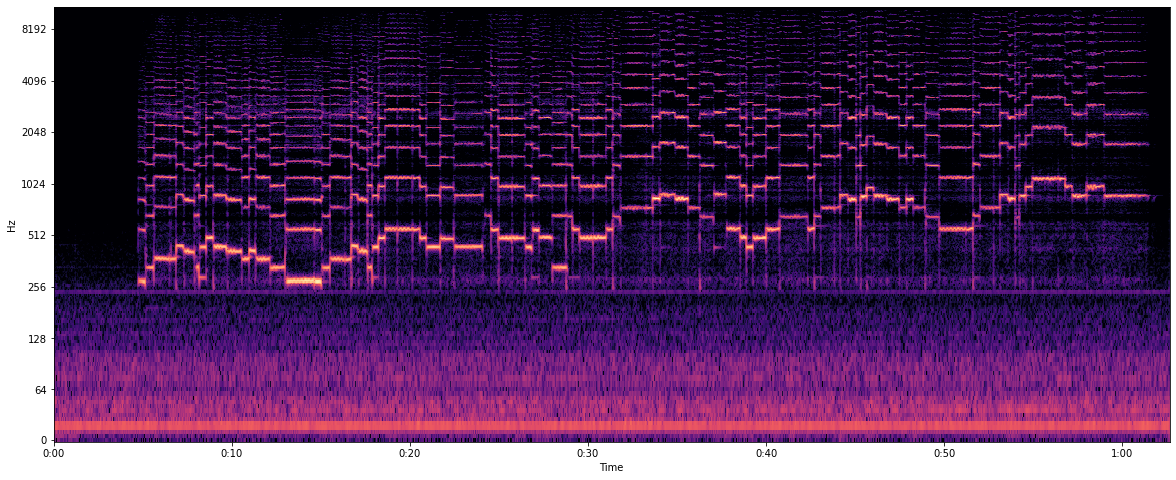

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8), sharex = True)
img = librosa.display.specshow(
    librosa.amplitude_to_db(
    abs(librosa.stft(audio[0], hop_length=256, n_fft=4096)),
    ref=np.max),
    ax = ax, hop_length=256, x_axis="time", y_axis="log")
fig.colorbar(ax=ax, format="%+2.f dB")

C:\Users\User\AppData\Local\Temp\ipykernel_529764\564188660.py:9: FutureWarning: Pass y=[-0.00353769 -0.00547527 -0.00477901 ...  0.00227958  0.00225402
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_boundaries = librosa.onset.onset_detect(


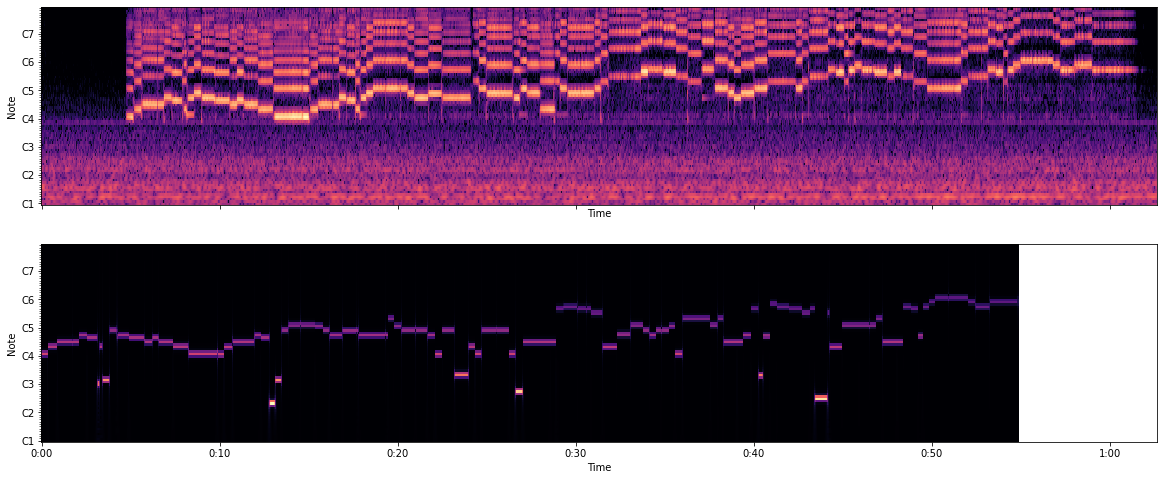

In [7]:
# Librosa method of generating sheet music
filename = "data/01_Jupiter_vn_vc/AuSep_1_vn_01_Jupiter.wav"
audio = librosa.load("../../" + filename)
C = np.abs(librosa.cqt(audio[0]))

fig, ax = plt.subplots(2, 1, figsize = (20, 8), sharex = True)
librosa.display.specshow(librosa.amplitude_to_db(C, ref = np.max), ax = ax[0], sr=audio[1], x_axis='time', y_axis='cqt_note')

onset_boundaries = librosa.onset.onset_detect(
    audio[0],
    sr=audio[1], units='samples', 
    backtrack = True,
)

# y = np.concatenate([
#     estimate_pitch_and_generate_sine(audio[0], onset_boundaries, i, sr=audio[1])
#     for i in range(len(onset_boundaries)-1)
# ])
# print(y)
# librosa.display.specshow(abs(y), sr=audio[1], x_axis='time', y_axis='cqt_note')
# plt.figure(figsize = (20, 8))
# librosa.display.waveshow(audio[0], sr=audio[1], ax = ax[1])
# plt.vlines(onset_boundaries, -.25, .25, color='r')

y = np.concatenate([
    estimate_pitch_and_generate_sine(audio[0], onset_boundaries, i, sr=audio[1])
    for i in range(len(onset_boundaries)-1)
])

librosa.display.specshow(abs(librosa.cqt(y, sr = audio[1])), ax = ax[1], sr=audio[1], x_axis='time', y_axis='cqt_note')

#ipd.Audio(y, rate = audio[1])

In [1]:
import mido

import librosa, librosa.display

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from torch.nn import Transformer
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss
import torch

## Model

In [2]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

wsin,wcos = create_filters(d,k)

with torch.cuda.device(0):
    wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
    wcos_var = Variable(torch.from_numpy(wcos).cuda(), requires_grad=False)
    
def init_weights(scale=0.):
    wscale = 0.
    with torch.cuda.device(0):
        beta = Variable(wscale*torch.rand([regions*k,m]).cuda(), requires_grad=True)
        betaavg = Variable(beta.data.clone(), requires_grad=False)
    return (beta,), (betaavg,)

def forward(x, beta):
    zx = conv1d(x[:,None,:], wsin_var, stride=stride).pow(2) \
       + conv1d(x[:,None,:], wcos_var, stride=stride).pow(2)
    return torch.mm(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],regions*k), beta)

def L(y_hat, y, beta):
    # adjust for per-frame loss
    return mse_loss(y_hat, y)*128/2.# + .01*torch.mean(beta.pow(2.))

NameError: name 'd' is not defined

In [ ]:
# Encodes the position of a value using sin and cos functions
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False).cuda()
        return x
        

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
    
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output

    def attention(q, k, v, d_k, mask=None, dropout=None):
        scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
        if mask is not None:
                mask = mask.unsqueeze(1)
                scores = scores.masked_fill(mask == 0, -1e9)
        scores = F.softmax(scores, dim=-1)
            
        if dropout is not None:
            scores = dropout(scores)
            
        output = torch.matmul(scores, v)
        return output


In [ ]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [ ]:
# build an encoder layer with one multi-head attention layer and one # feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model).cuda()

    def forward(self, x, e_outputs, src_mask, trg_mask):
            x2 = self.norm_1(x)
            x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
            x2 = self.norm_2(x)
            x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs,
            src_mask))
            x2 = self.norm_3(x)
            x = x + self.dropout_3(self.ff(x2))
            return x
            
# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [ ]:
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super().__init__()
        self.N = N
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
        
    def forward(self, src, mask):
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super().__init__()
        self.N = N
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
        
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output
# we don't perform softmax on the output as this will be handled 
# automatically by our loss function

In [ ]:
d_model = 84
heads = 8
N = 6

model = Transformer(d_model, N, heads)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        
# this code is very important! It initialises the parameters with a
# range of values that stops the signal fading or getting too big.
# See this blog for a mathematical explanation.
optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

## Training

In [21]:
def train_model(epochs, print_every=100):
    
    model.train()
    
    start = time.time()
    temp = start
    
    total_loss = 0
    
    for epoch in range(epochs):
       
        for i, batch in enumerate(train_iter):
            filename = "data/01_Jupiter_vn_vc/AuMix_01_Jupiter_vn_vc.wav"
            audio = librosa.load("../../" + filename)
            C = np.abs(librosa.cqt(audio[0]))

            plt.figure(figsize = (20, 8))
            src = librosa.amplitude_to_db(C, ref=np.max)
            trg = np.zeros(shape = (84,1) )

            
            # the words we are trying to predict
            
            targets = trg[:, 1:].contiguous().view(-1)
            
            # create function to make masks using mask code above
            
            src_mask, trg_mask = create_masks(src, trg_input)
            
            preds = model(src, trg_input, src_mask, trg_mask)
            
            optim.zero_grad()
            
            loss = F.cross_entropy(preds.view(-1, preds.size(-1)),
            results, ignore_index=target_pad)
            loss.backward()
            optim.step()
            
            total_loss += loss.data[0]
            if (i + 1) % print_every == 0:
                loss_avg = total_loss / print_every
                print("time = %dm, epoch %d, iter = %d, loss = %.3f,
                %ds per %d iters" % ((time.time() - start) // 60,
                epoch + 1, i + 1, loss_avg, time.time() - temp,
                print_every))
                total_loss = 0
                temp = time.time()

(84, 2699)

<Figure size 1440x576 with 0 Axes>